# Brake Emission Modeling

## Dependencies

In [1]:
# !pip install xlsxwriter
# !pip install pandas
# !pip install numpy
# !pip install xgboost
# !pip install seaborn
# !pip install matplotlib
# !pip install lightgbm
# !pip install catboost
# !pip install shap
# !pip install optuna
# !pip install asammdf
# !pip install dask
# !pip install dask_jobqueue
# !pip install PyYAML
# !pip install scikit_learn

## Problem Definition

We have two use-cases with Brake Emissions

## Workflow 

1. Exploratory Data Analysis
    1. Data Import
    1. Data Overview - Numerical
    2. Data Overview - Visual
2. Data Preprocessing
    1. Cleaning
    2. Imputing
    3. Feature Extraction
    4. Data Split
    5. Encoding
    6. Variance Threshold
    7. Scaling
3. Modeling
    1. Raw Models
    2. Feature Elimination
    3. Hyperparameter Optimization
    4. Evaluation
4. Summary and Next Steps

## 1. Data Understanding

### 1.1 Data Import

In [2]:
import pandas as pd
from sklearn.calibration import LabelEncoder
import yaml
import os
from pathlib import Path
import numpy as np


current_path = Path(os.getcwd())
# Load config files from yaml
cfg = yaml.safe_load(open(current_path / "config/config.yaml", "r"))
data_path = cfg["paths"]["data"]
file_name = cfg["paths"]["file"]
data_path = Path(current_path) / data_path

# Read data from CSV
input_data_path = data_path / r"input_data"
csv_file_path = input_data_path / (file_name + ".csv")
df = pd.read_csv(csv_file_path, header=0, na_values=["---", "Unknown"])

# Function to clean column names
def clean_column_name(column_name):
    return column_name.strip().replace('[', '').replace(']', '').replace(' ', '_').replace('?', '').replace('/','per')

# Clean column names
df.columns = [clean_column_name(col) for col in df.columns]

columns_to_drop = []
if cfg["feature_selection"]["columns_to_drop"] is not None:
    columns_to_drop = cfg["feature_selection"]["columns_to_drop"]

df = df.drop(columns=columns_to_drop)


### 1.2. Data Overview - Numerical

In [3]:
print(f"\nDATASET SUMMARY\n")
print(df.describe(include="all"), "\n")
print(df.info(), "\n")


DATASET SUMMARY

       TestBedperTestBench  pipeDiameter_mm CyclePhase  CycleOrder  \
count                    1              1.0         67   67.000000   
unique                   1              NaN          2         NaN   
top                  TB103              NaN    Bedding         NaN   
freq                     1              NaN         40         NaN   
mean                   NaN            219.0        NaN    2.716418   
std                    NaN              NaN        NaN    1.357426   
min                    NaN            219.0        NaN    1.000000   
25%                    NaN            219.0        NaN    2.000000   
50%                    NaN            219.0        NaN    3.000000   
75%                    NaN            219.0        NaN    4.000000   
max                    NaN            219.0        NaN    5.000000   

        DistanceDriven_km  Vs_duration_speed_out_limits_% Vs_validation_-  \
count           64.000000                       64.000000       

***Review***

By checking the min-max values of numeric columns, the number of missing values, and the unique values of categorical features, we can identify whether there are logically inconsistent or questionable data points.
Here are the list of features which don't have enough data to represent (# of missing points > 0.5 * number of total rows):

* Measurment_ID
* TestBedperTestBench
* pipeDiameter_mm
* VehicleMarket_-
* VehicleMax._laden_mass_kg
* VehicleMax._vehicle_load_(MVL)_kg
* DiscType_-
* DiscSurface_-
* Piston_Area_cm^2

These will be removed from the dataframe due to high number of missing values.

### 1.3. Data Overview - Visual

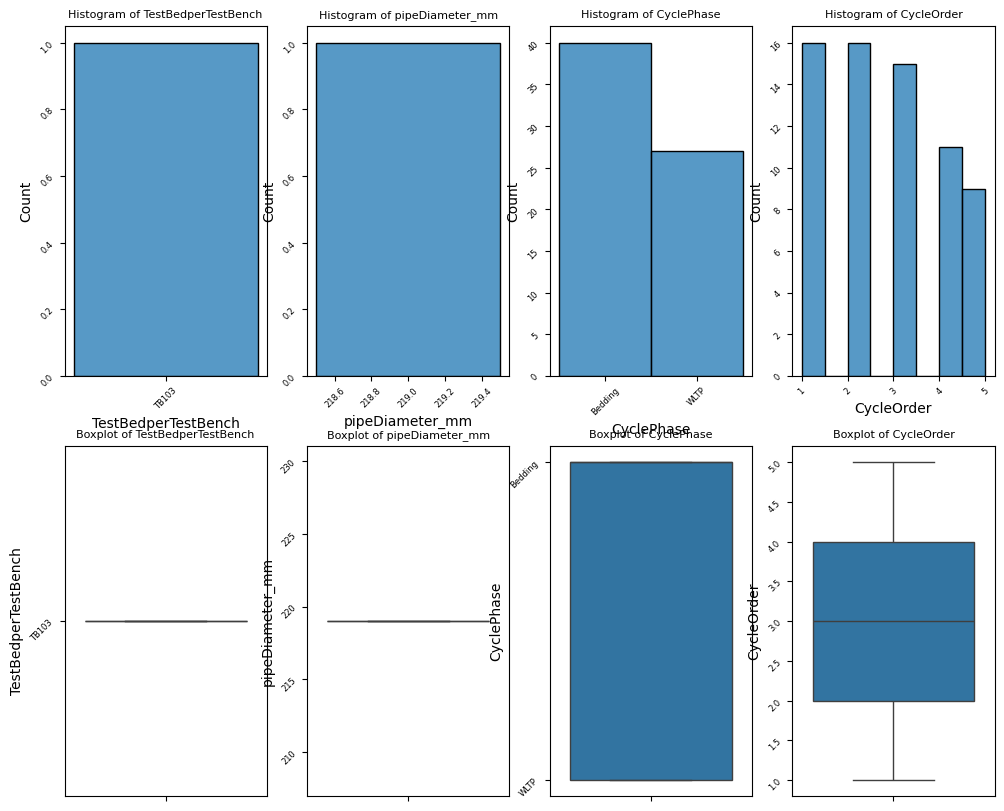

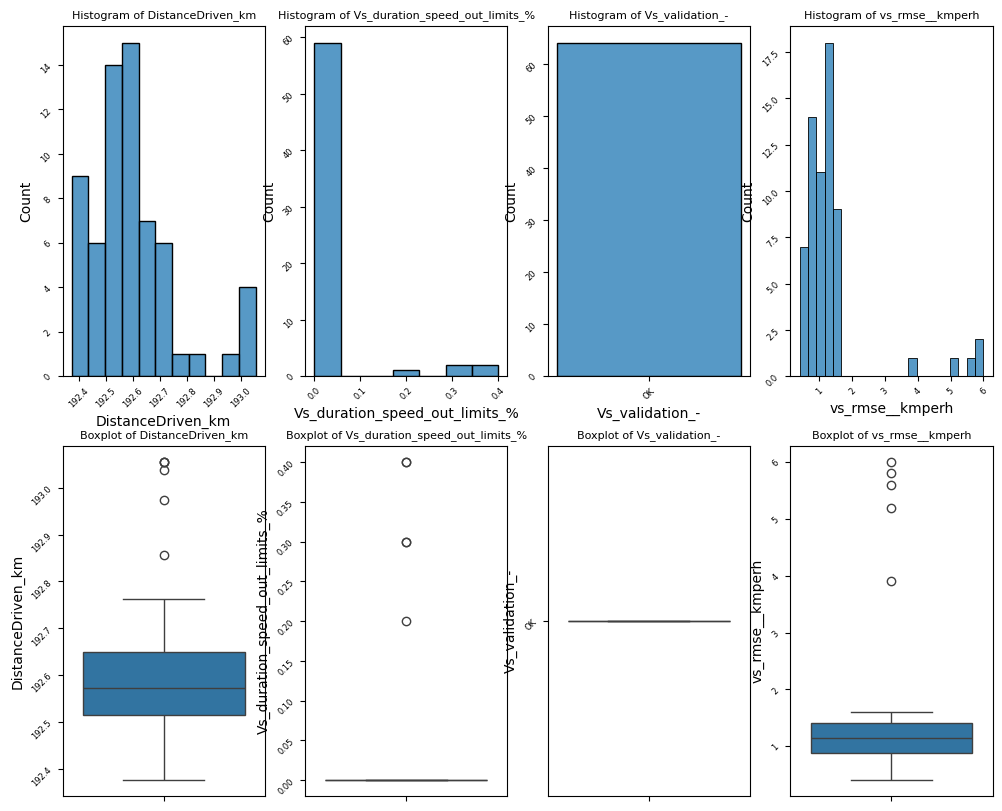

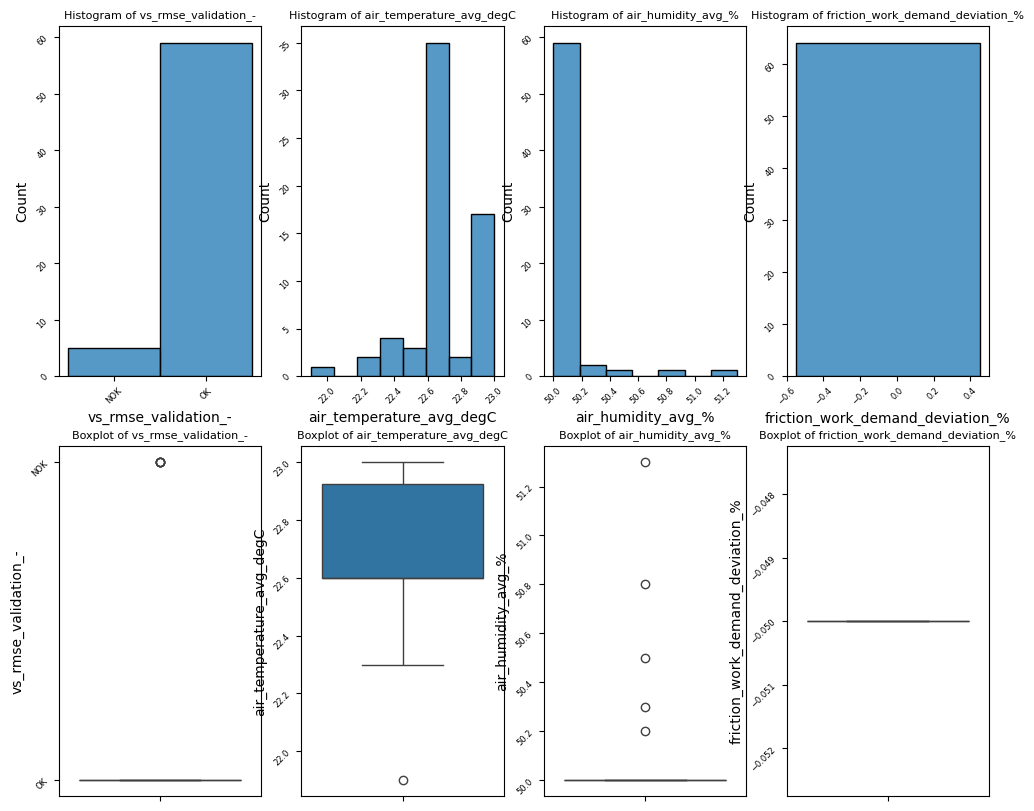

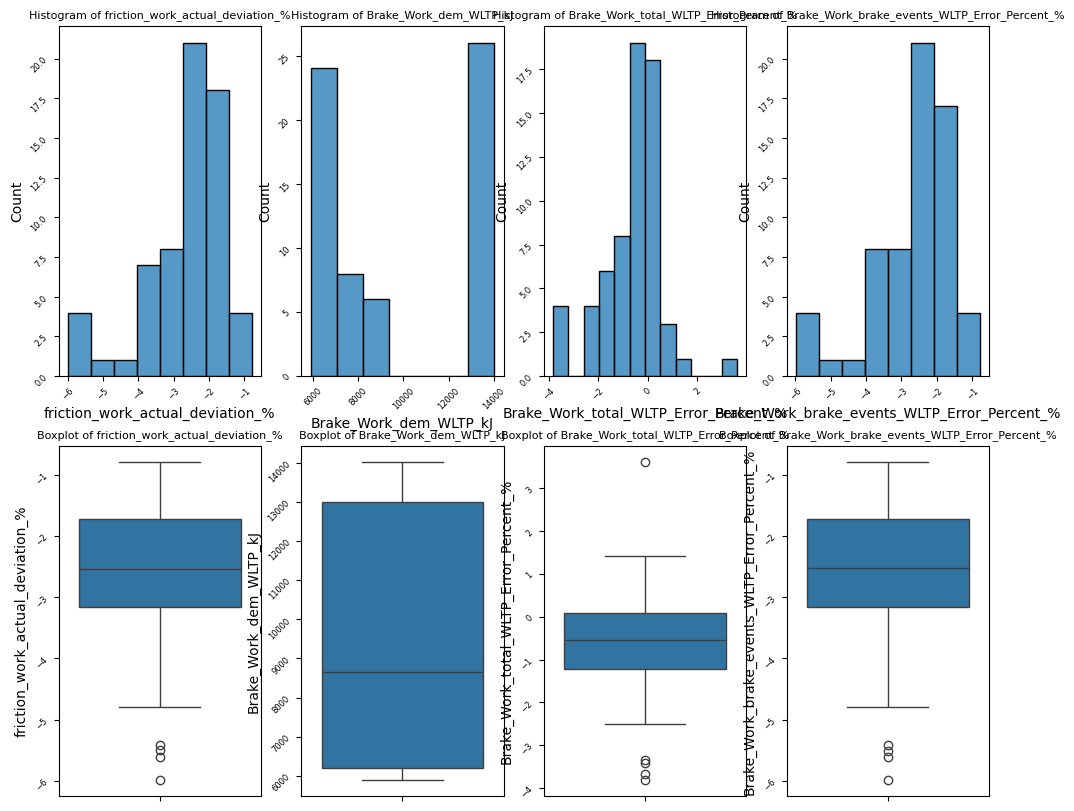

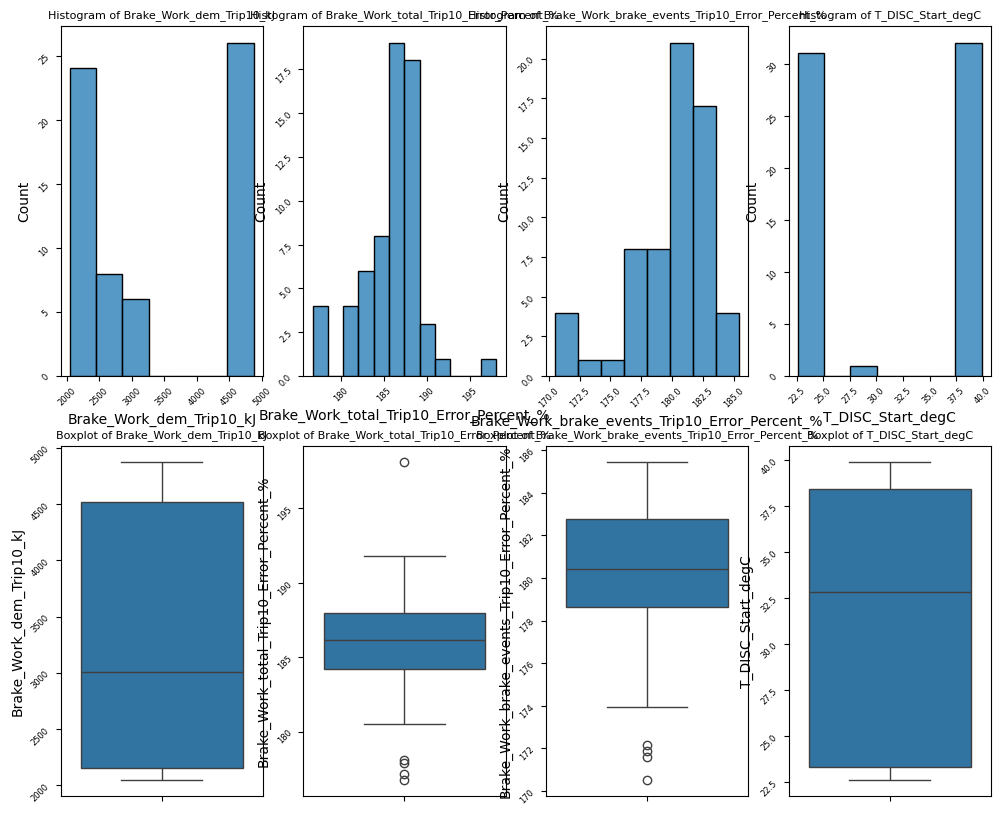

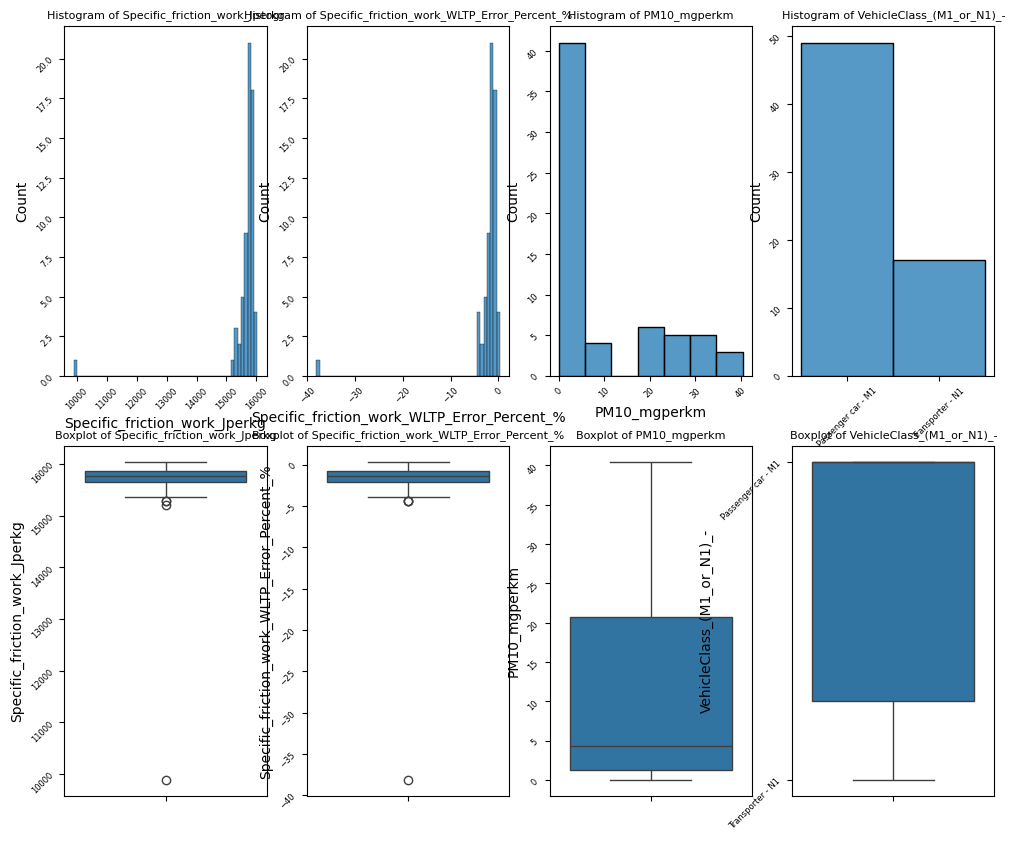

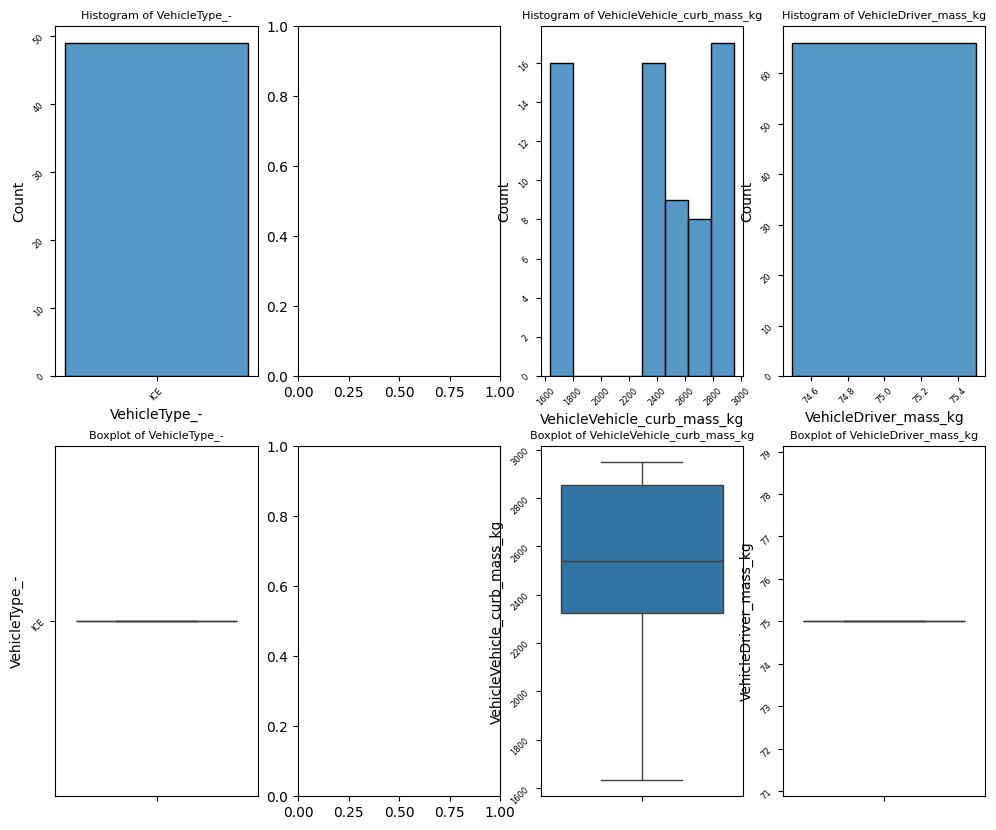

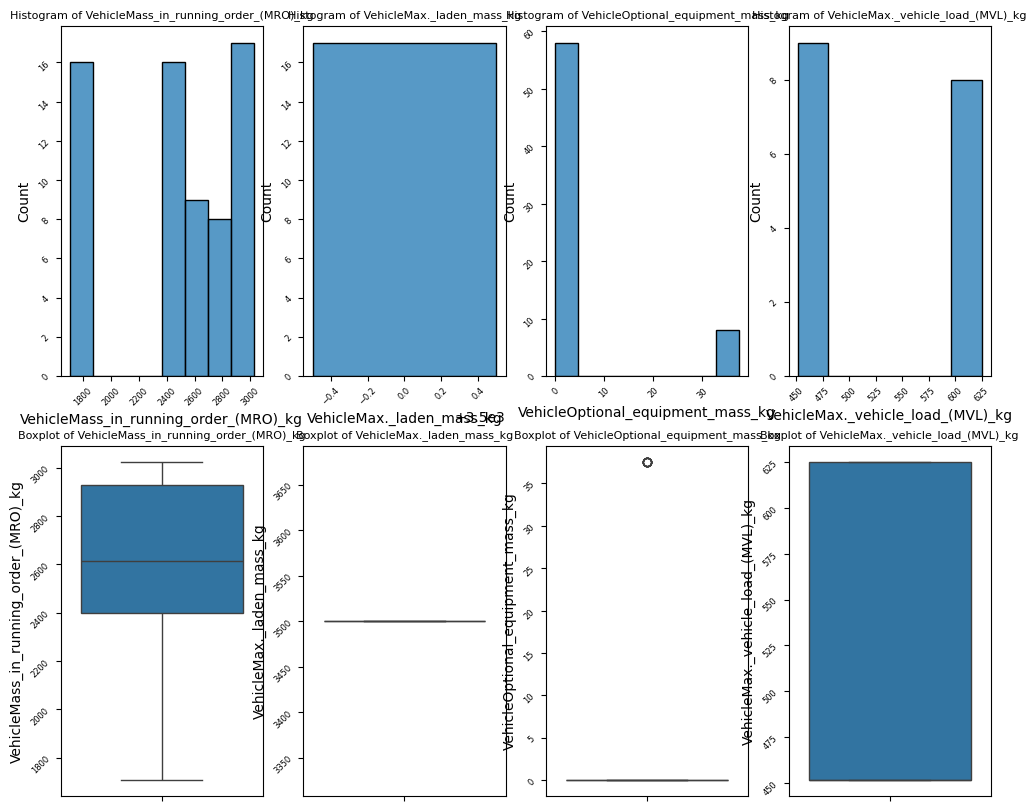

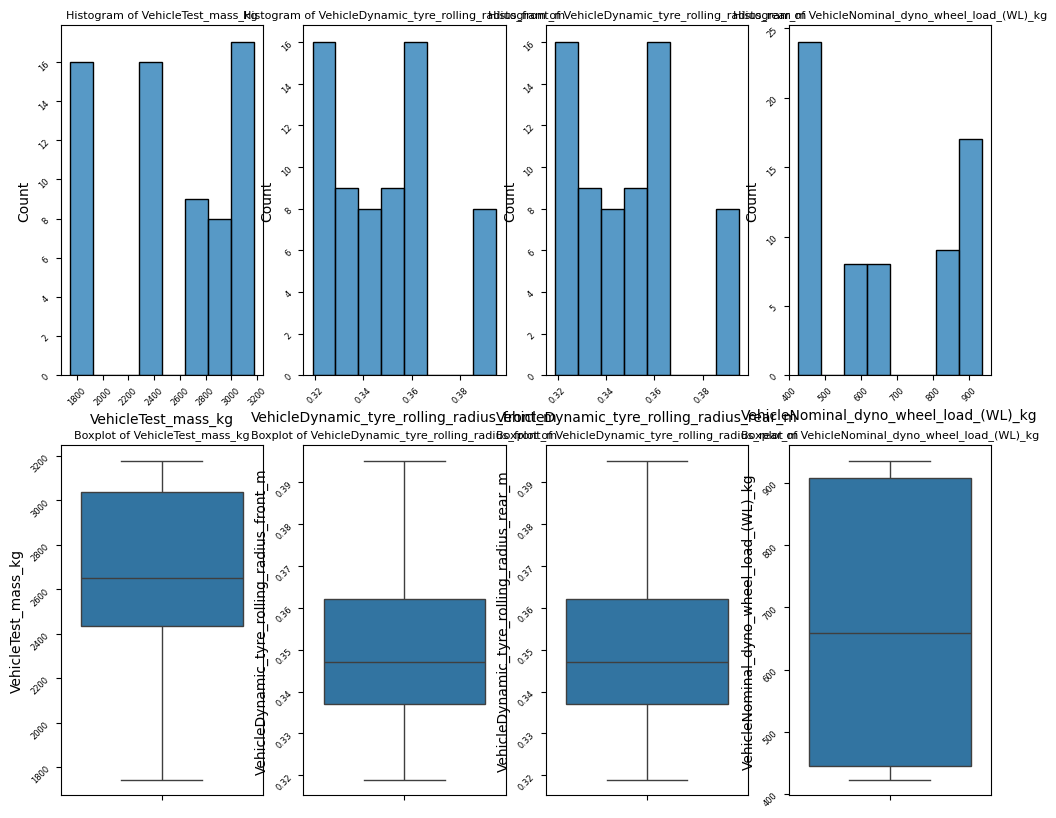

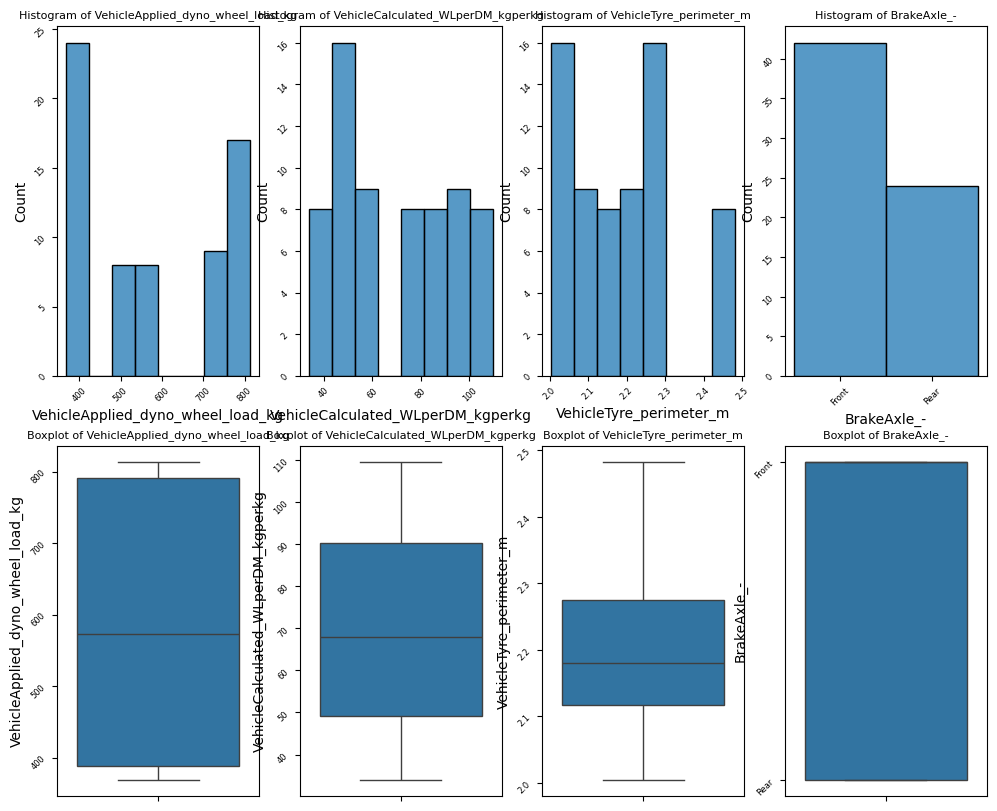

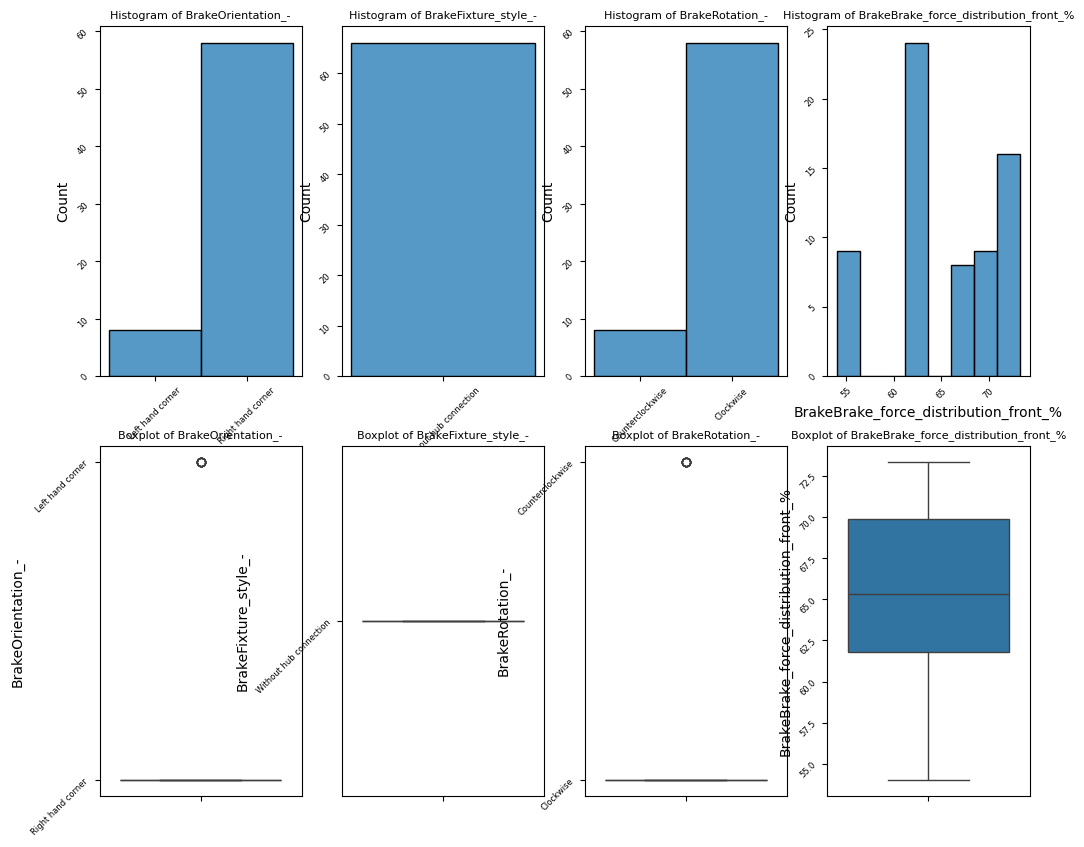

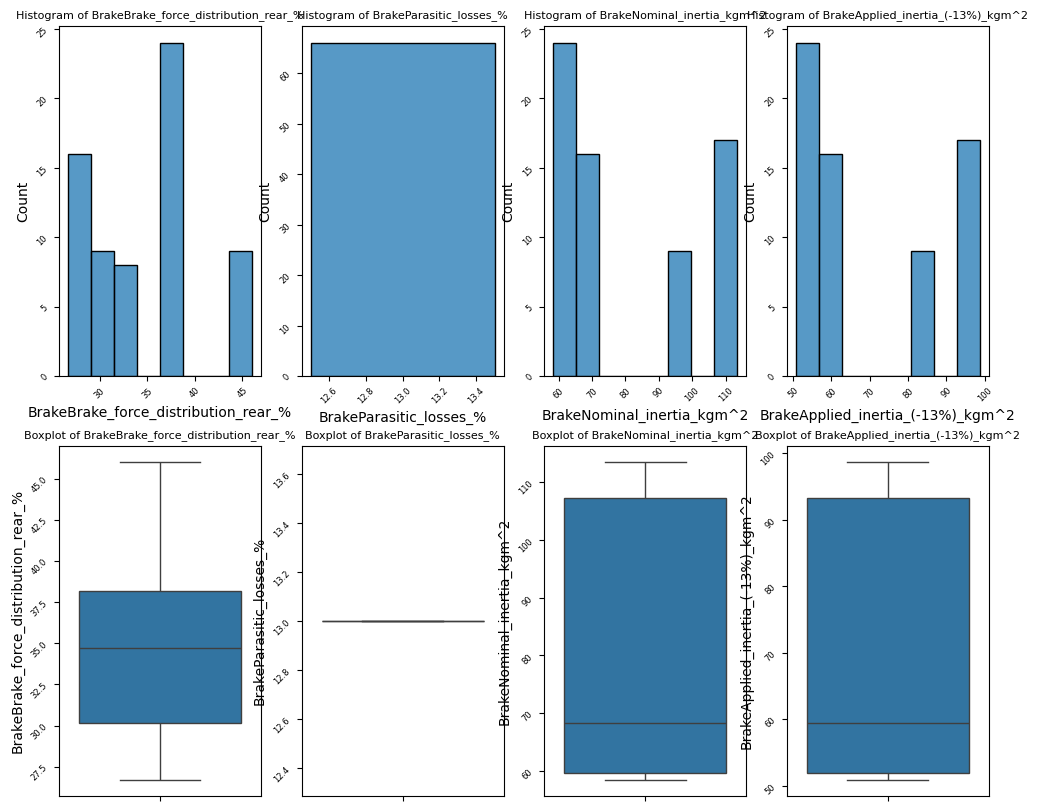

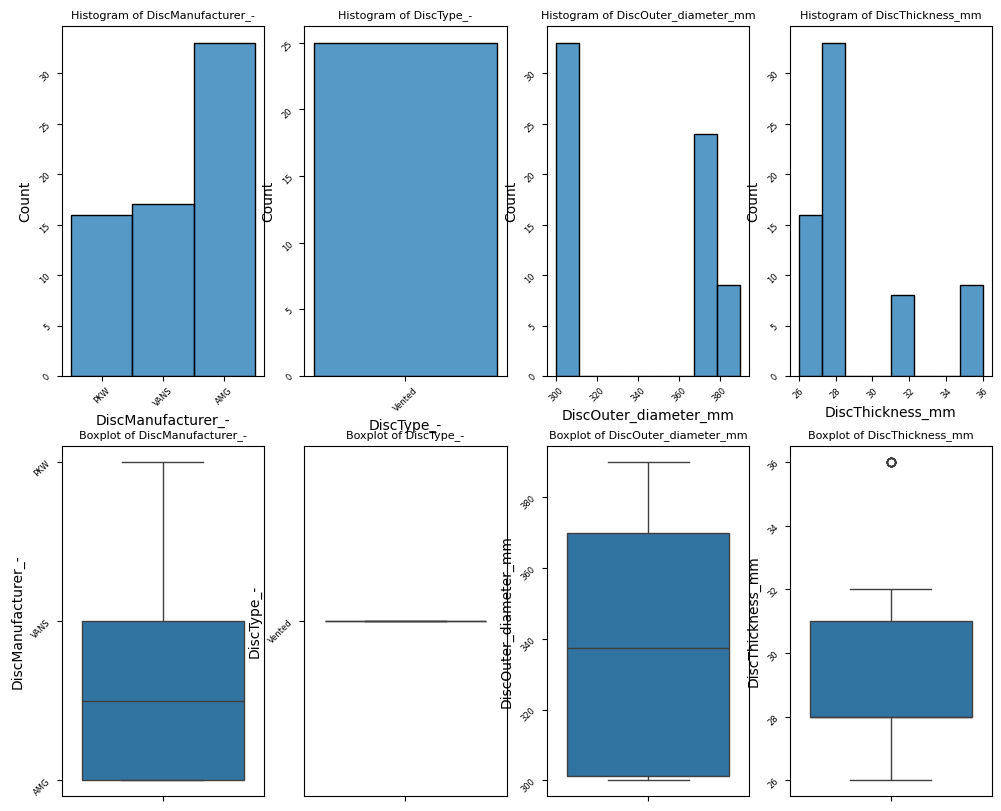

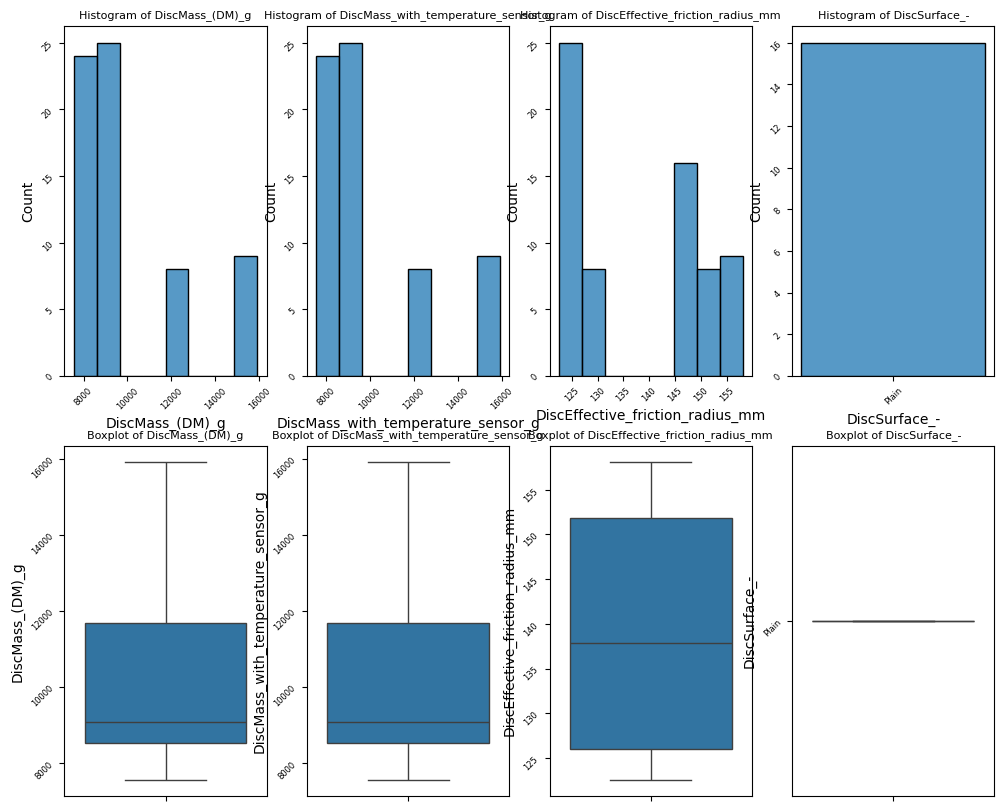

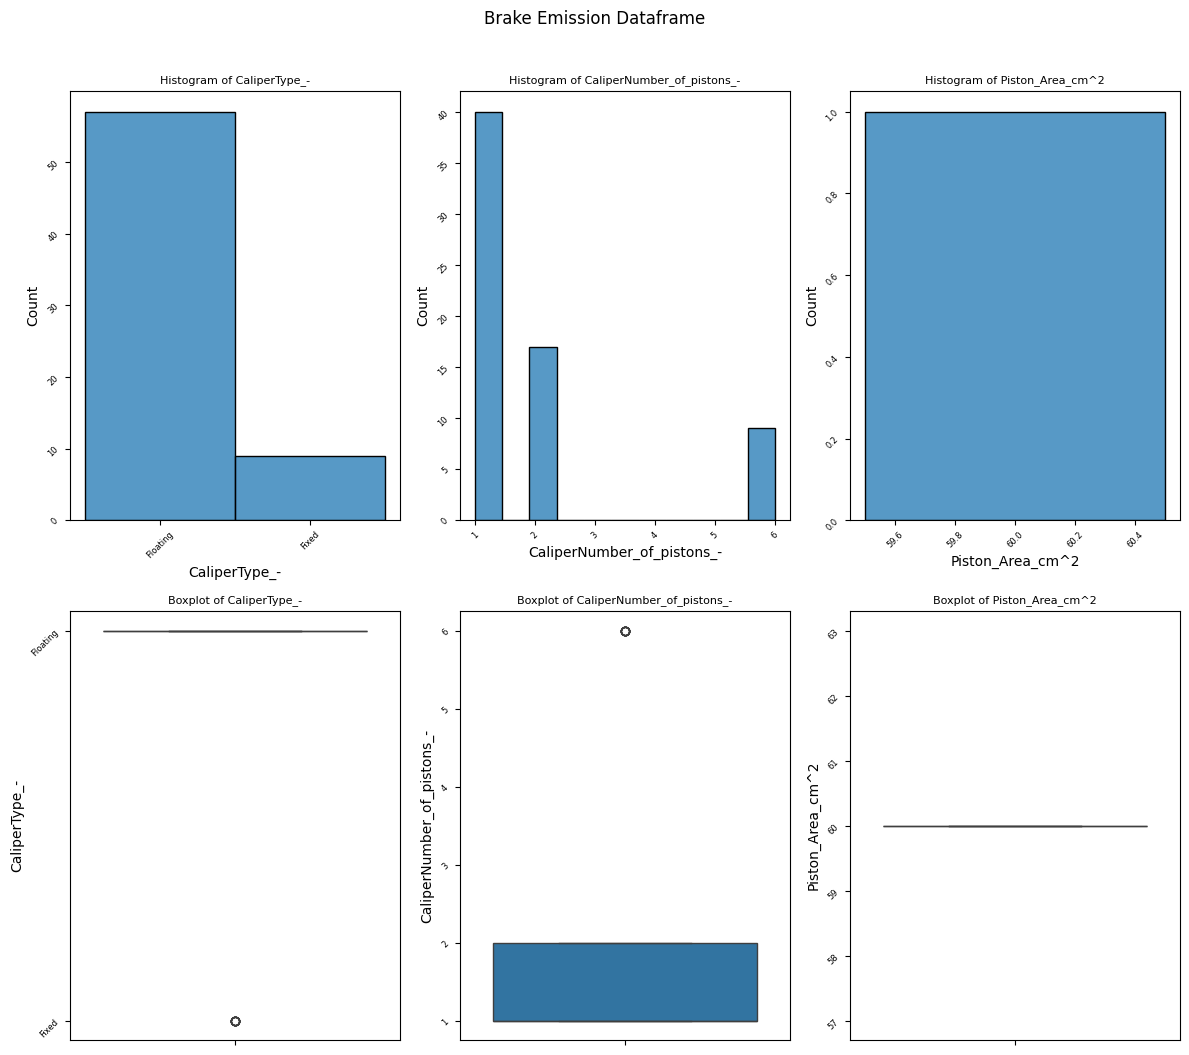

In [4]:
# Data Understanding Visually

# Create Histogram & Box Plots
import seaborn as sns
import matplotlib.pyplot as plt

def create_plots(df:pd.DataFrame):    
    # We already checked min-max for dates --> seems plausible no need to check the distribution since it will create too many categories 
    feature_columns = list(df.columns)

    # Detect categorical columns (non-categorical columns)
    categorical_columns = list(df.select_dtypes(include=["object"]).columns)

    numeric_columns = [col for col in feature_columns if col not in categorical_columns]

    feature_columns_per_4 = [feature_columns[i:i + 4] for i in range(0, len(feature_columns), 4)]

    # Plot histograms for each column
    for feature_column_list in feature_columns_per_4:
        # Create subplots with a smaller figure size
        fig, axes = plt.subplots(nrows=2, ncols=len(feature_column_list), figsize=(12, 10))
            
        for i, column in enumerate(feature_column_list):
            # Plot histogram
            if df[column].isnull().all():
                continue

            sns.histplot(df[column], ax=axes[0, i], kde=False)
            axes[0, i].set_title(f'Histogram of {column}', fontsize=8)
            axes[0, i].tick_params(axis='x', rotation=45, labelsize=6)  
            axes[0, i].tick_params(axis='y', rotation=45, labelsize=6)  

            # Plot box plot
            sns.boxplot(df[column], ax=axes[1, i])
            axes[1, i].set_title(f'Boxplot of {column}', fontsize=8)
            axes[1, i].tick_params(axis='x', rotation=45, labelsize=6)  
            axes[1, i].tick_params(axis='y', rotation=45, labelsize=6)  

        # Hide empty subplots (if any)
        for j in range(i+1, len(axes)):
            axes[j].axis('off')

    plt.tight_layout()
    plt.suptitle(f'Brake Emission Dataframe', fontsize=12, y=1.05)
    plt.show()

create_plots(df)

***Review***

By checking the min-max values, outliers, variations, and distributions of feature values,, we can identify whether there is a logically inconsistent or questionable data points.
Here are the list of features which don't have enough variation to see their effect on the model (# of nunique = 1):

'TestBedperTestBench', 'pipeDiameter_mm', 'Vs_validation_-',
       'friction_work_demand_deviation_%', 'VehicleType_-',
       'VehicleDriver_mass_kg', 'VehicleMax._laden_mass_kg',
       'BrakeFixture_style_-', 'BrakeParasitic_losses_%', 'DiscType_-',
       'DiscSurface_-', 'Piston_Area_cm^2'

These will be removed from the dataframe due to no variation in the dataset.

## 2. Data Preprocessing

### 2.1. Cleaning

We drop columns with less than half non-null values

In [5]:
df = df.dropna(axis=1, thresh=len(df)/2)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67 entries, 0 to 66
Data columns (total 51 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   CyclePhase                                      67 non-null     object 
 1   CycleOrder                                      67 non-null     int64  
 2   DistanceDriven_km                               64 non-null     float64
 3   Vs_duration_speed_out_limits_%                  64 non-null     float64
 4   Vs_validation_-                                 64 non-null     object 
 5   vs_rmse__kmperh                                 64 non-null     float64
 6   vs_rmse_validation_-                            64 non-null     object 
 7   air_temperature_avg_degC                        64 non-null     float64
 8   air_humidity_avg_%                              64 non-null     float64
 9   friction_work_demand_deviation_%             

Since we have a target column, we should also drop the rows in which the target column's value is missing.

In [ ]:
# Remove rows with NaN in the target column
df = df.dropna(subset=[cfg["feature_selection"]["target_column"]])

df = df[df[cfg["feature_selection"]["target_column"]] > 0]
df.info()

Then we remove the data which have no unique values

In [ ]:
# # Removal of no variation data
# df = df.drop(columns=df.columns[df.nunique() == 1])


# df.info()

In [ ]:
# Definition of features and the target
X = df.drop(columns=[cfg["feature_selection"]["target_column"]])
y = df[cfg["feature_selection"]["target_column"]]

In [ ]:

from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.01)
X_selected_np = selector.fit_transform(X)

# Get the boolean mask of retained features
retained_features_mask = selector.get_support()

# Get the column names of the retained features
retained_columns = X.columns[retained_features_mask]
eliminated_columns =  X.columns[~retained_features_mask]
X_train_selected = pd.DataFrame(X_selected_np, columns=retained_columns)

X_train_selected.info()
print(eliminated_columns)
print(retained_columns)

### 2.2. Imputing

Since there is no missing value in the remained features, we don't need to use imputing methods like IterativeImputer or KNNImputer. 

### 2.3. Feature Extraction

TBD later to change Cycle Type/Phase with the features extracted to define the cycles. 

### 2.4. Data Split

We will split our data into train and test datasets with 85 to 15 ratio to be able to train with X_train and evaluate the model with unseen X_test data.

In [ ]:
from sklearn.model_selection import train_test_split

# # Definition of features and the target
# X = df.drop(columns=[cfg["feature_selection"]["target_column"]])
# y = df[cfg["feature_selection"]["target_column"]]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train number of rows:", len(X_train))
print("X_test number of rows:", len(X_test))

### 2.5. Encoding

We will use for One hot encoder to convert categorical values to numeric values. Since the unique number of unique categories is not big for each categorical feature, we will not increase the dimensionality in a critical way. To avoid co-linearity, we will also drop the first columns. 

In [ ]:
from sklearn.preprocessing import OneHotEncoder

# Detect categorical columns (non-categorical columns)
categorical_columns = X_train.select_dtypes(include=["object"]).columns

# One-hot encoding
encoder = OneHotEncoder(sparse_output=False, drop="first")
X_train_encoded_categorical = encoder.fit_transform(X_train[categorical_columns])

# Convert encoded data to DataFrame
encoded_df = pd.DataFrame(X_train_encoded_categorical, columns=encoder.get_feature_names_out(categorical_columns), index=X_train.index)

# Concatenate encoded data with original DataFrame
X_train_encoded = pd.concat([X_train.drop(columns=categorical_columns), encoded_df], axis=1)

X_train_encoded.info("all")

In [ ]:
# Let's apply the fit encoding to the separated test sets (df_train_agg_test) as well
X_test_encoded_categorical = encoder.transform(X_test[categorical_columns])

# Convert the transformed data into a DataFrame
X_test_encoded_categorical = pd.DataFrame(X_test_encoded_categorical, columns=encoder.get_feature_names_out(categorical_columns), index=X_test.index)

# Concatenate the one-hot encoded DataFrame with the numerical columns
X_test_encoded = pd.concat([X_test.drop(columns=categorical_columns), X_test_encoded_categorical], axis=1)

# Encoded dataframe
print(X_test_encoded.info("all"))

### 2.6. Variance Threshold 

In [ ]:

from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.01)
X_train_selected_np = selector.fit_transform(X_train_encoded)
X_test_selected_np = selector.transform(X_test_encoded)

# Get the boolean mask of retained features
retained_features_mask = selector.get_support()

# Get the column names of the retained features
retained_columns = X_train_encoded.columns[retained_features_mask]
eliminated_columns =  X_train_encoded.columns[~retained_features_mask]
X_train_selected = pd.DataFrame(X_train_selected_np, columns=retained_columns)
X_test_selected = pd.DataFrame(X_test_selected_np, columns=retained_columns)

X_train_selected.info()
print(eliminated_columns)
print(retained_columns)

In [ ]:
X_train_selected["VehicleType_-_nan"]

### 2.7. Scaling

Especially for distance based algorithms (KNClassifier, SVC, etc.), we need to ensure that each feature has same effect by using a normalization method such as min-max scaling. Scaling also helps gradient descent to converge more quickly by providing same scaled features to have same effect on step size.
Although, tree based algorithms (Decision Trees, Bagging, Boosting, etc.) are robust to the different scales of features, we will not lose anything by scaling the features.

As for scaling we have two options: 
* Normalization (min-max): It can be used to scale the features between 0-1
* Standardization (z-score): It is used when the data follows Gaussian distribution (around its mean)

We can check data distribution plots to decide which scaling method to use. 

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Scaler definition
scaler = MinMaxScaler()

# Fit scaler to data and transform data
columns = X_train_selected.columns
X_train_selected[columns] = scaler.fit_transform(X_train_selected[columns])

print("\n Scaled data (Min-Max scaled):\n", X_train_selected.min(), X_train_selected.max())

In [ ]:
# Transform the df_test and df_target_train_test (the one we separated for internal model performance evaluation) 
X_test_selected[columns] = scaler.transform(X_test_selected[columns])

## 3. Modeling

While considering above mentioned points, the workflow is defined as follows:

1. Raw Models
2. Feature Elimination
3. Hyperparameter Optimization
4. Evaluation

We will evaluate each model trial with below metrics which are commonly used, robust, and easily interpretible regression metrics.

* ***Normalized Root Mean Square Error (NRMSE)***: 
    * A measure of the error relative to the range of the target variable, making it easier to compare across different datasets and different target variables
    * Model performance gets better as NRMSE decreases
    * Perfect model score = 0 | Worst model score = 1

We will use below models for training (in combination with cross validation to avoid overfitting).
* K-Neighbors Regressor
* XGBRegressor
* LGBMRegressor
* CatBoostRegressor

### 3.1. Raw Models

In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import make_scorer

from utils.helpers import Metrics


# Definition of model input and output
X = X_train_selected.copy()
y = y_train.copy()
X_test = X_test_selected.copy()

# Create a folder for results
trial_name = "raw_model"
timestamp = pd.Timestamp.now().strftime('%Y-%m-%d_%H-%M-%S')
results_folder = f"data/model_results_{trial_name}_{timestamp}"
os.makedirs(results_folder)

# Make the evaluation metrics into scorers
nrmse_scorer = make_scorer(Metrics.nrmse, greater_is_better=False)

# Define the models
models = {
    'KNeighborsRegressor': KNeighborsRegressor(),
    'XGBRegressor': XGBRegressor(),
    'LGBMRegressor': LGBMRegressor(verbose=-1),
}

# Define the metrics
metrics = ["NRMSE"]

# Initialize results dictionary
results = {}

# Set up cross-validation
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

results[trial_name] = {}

for model_name, model in models.items():
    
    print(f"\nRUNNING {model_name}...\n")

    results[trial_name][model_name] = {}

    # Initialize metric lists to store evaluation metrics for each fold
    metrics = Metrics("Training Dataset")

    results[trial_name][model_name] = {}

    # True vs Predicted Scatter Plots for each fold
    fig = plt.figure(figsize=(20, 3))

    # Perform cross-validation
    for ctr_fold, (train_index, test_index) in enumerate(kf.split(X_train_selected)):
        print(f"Fold {ctr_fold+1}/{n_splits}")

        X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
        y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]

        # Train the model
        model.fit(X_train_cv, y_train_cv)
        
        # Make predictions
        y_pred_cv = model.predict(X_test_cv)
        
        # Calculate evaluation metrics
        metrics_dict = metrics.calculate_metrics(y_test_cv, y_pred_cv)
        metrics.add_metrics(metrics_dict)

        file_name_prefix = f"{model_name}_CV{ctr_fold}"
        plot_title = f"{model_name}_CV{ctr_fold}"

        ax = plt.subplot(1, 5, ctr_fold + 1)
        ax = metrics.plot_true_vs_model(y_test_cv, y_pred_cv, ax, plot_title)

        print(f"NRMSE: {metrics_dict['nrmse']}")

    plt.tight_layout()
    plt.show()
    fig.savefig(f"{results_folder}/{model_name}_CV_predicted_vs_actual.png")

    # Display results
    metrics.compute_statistics()
    metrics.print_statistics_table()

    # Train the model with training dataset
    model.fit(X, y)
    results[trial_name][model_name]["model"] = model

    # Predict probabilities on the validation set
    y_pred_test = model.predict(X_test)

    # Calculate Metrics
    metrics_test = Metrics("Test Dataset")
    metrics_test_dict = metrics.calculate_metrics(y_test, y_pred_test)
    metrics_test.add_metrics(metrics_test_dict)

    # Compute statistics
    metrics_test.compute_statistics()
    metrics_test.print_statistics_table()
    
    # True vs Predicted Scatter Plots for each fold
    fig = plt.figure(figsize=(4, 3))
    ax = plt.subplot(1, 1, 1)
    metrics_test.plot_true_vs_model(y_test, y_pred_test, ax, "Test")
    plt.tight_layout()
    plt.show()
    fig.savefig(f"{results_folder}/{model_name}_TEST_predicted_vs_actual.png")

    # Log results
    results[trial_name][model_name]["Train"] = metrics
    results[trial_name][model_name]["Test"] = metrics_test

    print(f"FINISHED {model_name}...\n")

In [ ]:
import pandas as pd
import numpy as np

# Initialize lists to store results
regressor_names = []
train_performance = []
test_performance = []

# Extract performance metrics
for workflow_step, regressor in results.items():
    for regressor_name, df_results in regressor.items():
        regressor_names.append(regressor_name)
        train_performance.append(np.round(np.mean(df_results["Train"].metric_values["nrmse"][:]), 3))
        test_performance.append(np.round(df_results["Test"].metric_values["nrmse"][0], 3))

    # Create a DataFrame
    performance_df = pd.DataFrame({
        "Regressor": regressor_names,
        "Train Performance": train_performance,
        "Test Performance": test_performance
    })

    # Print the DataFrame
    print(f"\n{workflow_step} Results:\n")
    print(performance_df.to_string(index=False))


### 3.2. Feature Elimination

**Multi-collinearity**

To avoid multi-collinearity, we need to remove one of the highly correlated features. 
Reducing the number of highly correlated features has a positive impact on the modeling workflow:
* Easier model interpretation with less number of features
* Avoid overfitting
* Faster convergence
* Improved performance 

In [ ]:
df_train = pd.concat([X_train_selected, y_train], axis=1)

In [ ]:
import seaborn as sns
# Move the target column to the first position
columns_ordered = [cfg["feature_selection"]["target_column"]] + [col for col in df_train.columns if col != cfg["feature_selection"]["target_column"]]
df_model_train = df_train[columns_ordered]

# Compute the correlation matrix
corr = df_train.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Create a mask to have clear picture
mask = np.triu(np.ones_like(corr, dtype=bool))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, vmin=-1, vmax=1, center=0, mask=mask,
            square=True, linewidths=.5, cbar_kws={"shrink": 0.6})

ax.set_xticklabels(ax.get_xticklabels(), horizontalalignment='center', fontdict={"fontsize": 7})
ax.set_yticklabels(ax.get_yticklabels(), horizontalalignment='right', fontdict={"fontsize": 7})

# Annotate each cell with the correlation value
for i in range(corr.shape[0]):
    for j in range(corr.shape[1]):
        if j>i:
            break
        ax.text(j + 0.5, i + 0.5, f'{corr.iloc[i, j]:.1f}', ha='center', va='center', color='black', fontdict={"fontsize": 6})

plt.show()

In [ ]:
import numpy as np

# Retain essential features
essential_features = [cfg["feature_selection"]["target_column"]]

# We should be careful for removing both features which are correlated 
correlation_matrix = df_model_train.corr().abs()

# Select upper triangle of correlation matrix
upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than threshold
threshold = 0.95
to_remove = set()
print("Multi-collinearity List:\n")
for col in upper.columns:
    correlated_features = list(upper.index[upper[col] > threshold])
    if correlated_features:
        print(col, ":", correlated_features) 
        to_remove.add(col)

to_keep = list(set(df_model_train.columns) - set(to_remove))

print("\nRemoved Features: \n")
[print(f"* {col}") for col in to_remove]


# Remove redundant features
if cfg["feature_selection"]["target_column"] in to_keep:
    to_keep.remove(cfg["feature_selection"]["target_column"])

# Create new DataFrame with selected features
X_train_wout_collinear = df_model_train[to_keep].copy()

print("\nRemained Features: \n")
X_train_wout_collinear.info()


In [ ]:
import seaborn as sns
# Move the target column to the first position
columns_after_cleaning = to_keep + essential_features
columns_ordered = [col for col in X_train_wout_collinear] + [cfg["feature_selection"]["target_column"]]
df_model_train_cleaned = df_model_train[columns_after_cleaning][columns_ordered]

# Compute the correlation matrix
corr = df_model_train_cleaned.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Create a mask to have clear picture
mask = np.triu(np.ones_like(corr, dtype=bool))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, vmin=-1, vmax=1, center=0, mask=mask,
            square=True, linewidths=.5, cbar_kws={"shrink": 0.6})

ax.set_xticklabels(ax.get_xticklabels(), horizontalalignment='center', fontdict={"fontsize": 9})
ax.set_yticklabels(ax.get_yticklabels(), horizontalalignment='right', fontdict={"fontsize": 9})

# Annotate each cell with the correlation value
for i in range(corr.shape[0]):
    for j in range(corr.shape[1]):
        if j>i:
            break
        ax.text(j + 0.5, i + 0.5, f'{corr.iloc[i, j]:.1f}', ha='center', va='center', color='black', fontdict={"fontsize": 8})

plt.show()

In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import make_scorer

from utils.helpers import Metrics


# Definition of model input and output
X = X_train_selected[to_keep].copy()
y = y_train.copy()
X_test = X_test_selected[to_keep].copy()

# Create a folder for results
trial_name = "raw_model_wout_collinear"
timestamp = pd.Timestamp.now().strftime('%Y-%m-%d_%H-%M-%S')
results_folder = f"data/model_results_{trial_name}_{timestamp}"
os.makedirs(results_folder)

# Make the evaluation metrics into scorers
nrmse_scorer = make_scorer(Metrics.nrmse, greater_is_better=False)

# Define the models
models = {
    'KNeighborsRegressor': KNeighborsRegressor(),
    'XGBRegressor': XGBRegressor(),
    'LGBMRegressor': LGBMRegressor(verbose=-1),
}

# Define the metrics
metrics = ["NRMSE"]

# Set up cross-validation
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

results[trial_name] = {}

for model_name, model in models.items():
    
    print(f"\nRUNNING {model_name}...\n")

    results[trial_name][model_name] = {}

    # Initialize metric lists to store evaluation metrics for each fold
    metrics = Metrics("Training Dataset")

    results[trial_name][model_name] = {}

    # True vs Predicted Scatter Plots for each fold
    fig = plt.figure(figsize=(20, 3))

    # Perform cross-validation
    for ctr_fold, (train_index, test_index) in enumerate(kf.split(X_train_selected)):
        print(f"Fold {ctr_fold+1}/{n_splits}")

        X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
        y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]

        # Train the model
        model.fit(X_train_cv, y_train_cv)
        
        # Make predictions
        y_pred_cv = model.predict(X_test_cv)
        
        # Calculate evaluation metrics
        metrics_dict = metrics.calculate_metrics(y_test_cv, y_pred_cv)
        metrics.add_metrics(metrics_dict)

        file_name_prefix = f"{model_name}_CV{ctr_fold}"
        plot_title = f"{model_name}_CV{ctr_fold}"

        ax = plt.subplot(1, 5, ctr_fold + 1)
        ax = metrics.plot_true_vs_model(y_test_cv, y_pred_cv, ax, plot_title)

        print(f"NRMSE: {metrics_dict['nrmse']}")

    plt.tight_layout()
    plt.show()
    fig.savefig(f"{results_folder}/{model_name}_CV_predicted_vs_actual.png")

    # Display results
    metrics.compute_statistics()
    metrics.print_statistics_table()

    # Train the model with training dataset
    model.fit(X, y)
    results[trial_name][model_name]["model"] = model

    # Predict probabilities on the validation set
    y_pred_test = model.predict(X_test)

    # Calculate Metrics
    metrics_test = Metrics("Test Dataset")
    metrics_test_dict = metrics.calculate_metrics(y_test, y_pred_test)
    metrics_test.add_metrics(metrics_test_dict)

    # Compute statistics
    metrics_test.compute_statistics()
    metrics_test.print_statistics_table()
    
    # True vs Predicted Scatter Plots for each fold
    fig = plt.figure(figsize=(4, 3))
    ax = plt.subplot(1, 1, 1)
    metrics_test.plot_true_vs_model(y_test, y_pred_test, ax, "Test")
    plt.tight_layout()
    plt.show()
    fig.savefig(f"{results_folder}/{model_name}_TEST_predicted_vs_actual.png")

    # Log results
    results[trial_name][model_name]["Train"] = metrics
    results[trial_name][model_name]["Test"] = metrics_test

    print(f"FINISHED {model_name}...\n")

In [ ]:
import pandas as pd
import numpy as np

# Extract performance metrics
for workflow_step, regressor in results.items():
    # Initialize lists to store results
    regressor_names = []
    train_performance = []
    test_performance = []

    for regressor_name, df_results in regressor.items():
        regressor_names.append(regressor_name)
        train_performance.append(np.round(np.mean(df_results["Train"].metric_values["nrmse"][:]), 3))
        test_performance.append(np.round(df_results["Test"].metric_values["nrmse"][0], 3))

    # Create a DataFrame
    performance_df = pd.DataFrame({
        "Regressor": regressor_names,
        "Train Performance": train_performance,
        "Test Performance": test_performance
    })

    # Print the DataFrame
    print(f"\n{workflow_step} Results:\n")
    print(performance_df.to_string(index=False))


XGBRegressor shows very promising results with improvement in terms of %59 NRMSE in training and %32 NRMSE in testing data. Therefore, we will continue with this modeling technique from now now.

**Recursive Feature Elimination w Cross Validation**

* We will use Recursive Feature Elimination w Cross Validation method, since it helps to eliminate less important features in an easy and robust way. 
* As for the feature importances, we will utilize shap value to represent the most important features since it shows positive/negative impact of each feature and their values to the model performance.   

In [ ]:
from sklearn.feature_selection import RFE, RFECV
import shap
# from probatus.feature_elimination import ShapRFECV

# Definition of model input and output
X = X_train_selected[to_keep].copy()
y = y_train.copy()
X_test = X_test_selected[to_keep].copy()

# Create a folder for results
trial_name = "raw_model_wout_collinear_RFECV"
timestamp = pd.Timestamp.now().strftime('%Y-%m-%d_%H-%M-%S')
results_folder = f"data/model_results_{trial_name}_{timestamp}"
os.makedirs(results_folder)

# Make the evaluation metrics into scorers
nrmse_scorer = make_scorer(Metrics.nrmse, greater_is_better=False)

# Define the models
models = {
    # 'KNeighborsRegressor': KNeighborsRegressor(),
    'XGBRegressor': XGBRegressor(),
    # 'LGBMRegressor': LGBMRegressor(verbose=-1),
}

# Define the metrics
metrics = ["NRMSE"]

# Set up cross-validation
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

results[trial_name] = {}

for model_name, model in models.items():
    
    print(f"\nRUNNING {model_name}...\n")

    results[trial_name][model_name] = {}

    # Initialize RFE for feature selection
    rfecv = RFECV(estimator=model, step=1, cv=kf, min_features_to_select=7, scoring=nrmse_scorer, verbose=0)
    # rfecv = ShapRFECV(model=model, step=1, cv=kf, min_features_to_select=5, scoring="neg_root_mean_squared_error", verbose=0)
    
    print(f"FEATURE SELECTION FOR {model_name} STARTED...\n")

    # Fit RFECV on the data
    rfecv.fit(X, y)
    # rfecv.fit_compute(X, y)
    # rfecv.plot()

    # Get the selected features
    X_w_less_feat = rfecv.transform(X)
    
    # Get the selected feature names
    selected_features = X.columns[rfecv.get_support(indices=True)]
    
    # Create a DataFrame with selected features
    X_train_selected = pd.DataFrame(X_w_less_feat, columns=selected_features)

    # Print the optimal number of features
    print("Optimal number of features : %d" % rfecv.n_features_)
    
    # Print the selected feature names
    print("Selected features:", print(selected_features))

    results[trial_name][model_name]["selected_features"] = selected_features
    
    print(f"\nCV WITH SELECTED FEATURES FOR {model_name} STARTED...\n")

    # Initialize metric lists to store evaluation metrics for each fold
    metrics = Metrics("Training Dataset")

    results[trial_name][model_name] = {}

    # True vs Predicted Scatter Plots for each fold
    fig = plt.figure(figsize=(20, 3))

    # TODO: duplicate code to be removed since RFECV is showing CV results already
    # Perform cross-validation
    for ctr_fold, (train_index, test_index) in enumerate(kf.split(X_train_selected)):
        print(f"Fold {ctr_fold+1}/{n_splits}")

        X_train_cv, X_test_cv = X_train_selected.iloc[train_index], X_train_selected.iloc[test_index]
        y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]

        # Train the model
        model.fit(X_train_cv, y_train_cv)
        
        # Make predictions
        y_pred_cv = model.predict(X_test_cv)
        
        # Calculate evaluation metrics
        metrics_dict = metrics.calculate_metrics(y_test_cv, y_pred_cv)
        metrics.add_metrics(metrics_dict)

        file_name_prefix = f"{model_name}_CV{ctr_fold}"
        plot_title = f"{model_name}_CV{ctr_fold}"

        ax = plt.subplot(1, 5, ctr_fold + 1)
        ax = metrics.plot_true_vs_model(y_test_cv, y_pred_cv, ax, plot_title)

        print(f"NRMSE: {metrics_dict['nrmse']}")

    plt.tight_layout()
    plt.show()
    fig.savefig(f"{results_folder}/{model_name}_CV_predicted_vs_actual.png")

    # Display results
    metrics.compute_statistics()
    metrics.print_statistics_table()

    # Train the model with training dataset
    model.fit(X_train_selected, y)
    results[trial_name][model_name]["model"] = model

    # Predict probabilities on the validation set
    X_test_selected = rfecv.transform(X_test)
    X_test_selected = pd.DataFrame(X_test_selected, columns=selected_features)

    # Predict y with the model trained with the remained features
    y_pred_test = model.predict(X_test_selected)

    # Calculate Metrics
    metrics_test = Metrics("Test Dataset")
    metrics_test_dict = metrics.calculate_metrics(y_test, y_pred_test)
    metrics_test.add_metrics(metrics_test_dict)

    # Compute statistics
    metrics_test.compute_statistics()
    metrics_test.print_statistics_table()
    
    # True vs Predicted Scatter Plots for each fold
    fig = plt.figure(figsize=(4, 3))
    ax = plt.subplot(1, 1, 1)
    metrics_test.plot_true_vs_model(y_test, y_pred_test, ax, "Test")
    plt.tight_layout()
    plt.show()
    fig.savefig(f"{results_folder}/{model_name}_TEST_predicted_vs_actual.png")

    # Log results
    results[trial_name][model_name]["Train"] = metrics
    results[trial_name][model_name]["Test"] = metrics_test

    print(f"FINISHED {model_name}...\n")

In [ ]:
import pandas as pd
import numpy as np

# Extract performance metrics
for workflow_step, regressor in results.items():
    # Initialize lists to store results
    regressor_names = []
    train_performance = []
    test_performance = []

    for regressor_name, df_results in regressor.items():
        regressor_names.append(regressor_name)
        train_performance.append(np.round(np.mean(df_results["Train"].metric_values["nrmse"][:]), 3))
        test_performance.append(np.round(df_results["Test"].metric_values["nrmse"][0], 3))

    # Create a DataFrame
    performance_df = pd.DataFrame({
        "Regressor": regressor_names,
        "Train Performance": train_performance,
        "Test Performance": test_performance
    })

    # Print the DataFrame
    print(f"\n{workflow_step} Results:\n")
    print(performance_df.to_string(index=False))


There is a slight improvement in both train & test results after RFE.

### Feature Importances

In [ ]:
model = results["raw_model_wout_collinear_RFECV"]["XGBRegressor"]["model"]

# Shapley values
print(f"FEATURE IMPORTANCES")
plt.figure()
explainer = shap.Explainer(model, X)
shap_values = explainer(X, check_additivity=False)
shap.plots.bar(shap_values, max_display=20)

plt.figure()
shap.plots.beeswarm(shap_values, max_display=20)

As it can be seen from the shapley values the most important parameters are:

* xx
* xx
* xx
* xx
* xx

### 3.3. Hyperparameter Optimization 

As for hyperparameter optimization, we will utilize optuna library since it is modular, parallelizable and the state of the art with large space search and escaping from unpromising trials.

In [ ]:
import os
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import make_scorer

from utils.helpers import Metrics


# Definition of model input and output
# X = X_train_encoded[to_keep].copy()
# y = y_train.copy()
# X_test = X_test_encoded[to_keep].copy()


X = X_train_selected.copy()
y = y_train.copy()
X_test = X_test_selected.copy()

# Definition of  parameter grids for each classifier
param_grids = {
    "XGBRegressor": {
        "objective": ["reg:squarederror"],
        "eval_metric": ["rmse"],
        'eta': [0.01, 0.30],
        "n_estimators": [100, 300],
        'max_depth': [3, 10],
        'min_child_weight': [1, 10],
        'subsample': [0.6, 0.8],
        'colsample_bytree': [0.6, 0.8],
        'gamma': [0, 0.2],
        'lambda': [1], 
        'alpha': [0],
        'seed': [42],
        "verbosity": [1]
    }
}
# Create a folder for results
trial_name = "raw_model_wout_collinear_hypopt"
timestamp = pd.Timestamp.now().strftime('%Y-%m-%d_%H-%M-%S')
results_folder = f"data/model_results_{trial_name}_{timestamp}"
os.makedirs(results_folder)

# Make the evaluation metrics into scorers
nrmse_scorer = make_scorer(Metrics.nrmse, greater_is_better=False)

# Define the models
models = {
    # 'KNeighborsRegressor': KNeighborsRegressor(),
    'XGBRegressor': XGBRegressor(),
    # 'LGBMRegressor': LGBMRegressor(verbose=-1),
}

# Define the metrics
metrics = ["NRMSE"]

# Set up cross-validation
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

results[trial_name] = {}

for model_name, model in models.items():
    
    print(f"\nRUNNING {model_name}...\n")

    results[trial_name][model_name] = {}

    # Initialize metric lists to store evaluation metrics for each fold
    metrics = Metrics("Training Dataset")

    results[trial_name][model_name] = {}

    
    def objective(trial):
        # Define parameter space for Optuna to search
        param_space = param_grids[model_name]

        # Sample parameters
        sampled_params ={}
        for key, value in param_space.items():
            if isinstance(value[0], int):
                if len(value) > 1:
                    sampled_params[key] = trial.suggest_int(key, value[0], value[1])
                else:
                    sampled_params[key] = trial.suggest_int(key, value[0], value[0], step=1)
            elif isinstance(value[0], float):
                if len(value) > 1:
                    sampled_params[key] = trial.suggest_float(key, value[0], value[1])
                else:
                    sampled_params[key] = trial.suggest_float(key, value[0], value[0], step=1)
            else:
                sampled_params[key] = trial.suggest_categorical(key, value)

        # Initialize classifier with sampled parameters
        model_opt = model.set_params(**sampled_params)

        # Initialize metric lists for cross-validation
        nrmse_scores = []

        # Perform cross-validation
        ctr = 1
        for train_idx, val_idx in kf.split(X, y):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            # Train the model
            model_opt.fit(X_train, y_train)

            # Predict probabilities on validation set
            y_pred = model_opt.predict(X_val)

            # Calculate Metrics
            metrics_dict = metrics.calculate_metrics(y_val, y_pred)

            # Append each fold's results
            nrmse_scores.append(metrics_dict["nrmse"])
        
            # Report intermediate objective value.
            trial.report(metrics_dict["nrmse"], ctr)

            ctr += 1
        
            # Handle pruning based on the intermediate value.
            if trial.should_prune():
                raise optuna.TrialPruned()
            
        # Return the negative PR AUC score since Optuna aims to minimize the objective
        return np.mean(nrmse_scores)

    # Create a study object and optimize the objective function
    # https://github.com/optuna/optuna/wiki/Benchmarks-with-Kurobako

    study = optuna.create_study(direction="minimize", pruner=optuna.pruners.HyperbandPruner())
    study.optimize(objective, n_trials=250)

    # Get the best parameters found by Optuna
    best_params = study.best_params

    # Initialize the best classifier with the best parameters found by Optuna
    best_clf = model.set_params(**best_params)

    # Train the model with the best parameters
    best_clf.fit(X, y)

    # Store the best classifier
    results[trial_name][model_name]["best_clf"] = best_clf

    print(f"\nBEST HYPERPARAMETERS FOUND BY OPTUNA FOR {model_name}:")
    print(best_params)

    print(f"\nCV WITH SELECTED HYPERPARAMETERS FOR {model_name} STARTED...\n")

    # True vs Predicted Scatter Plots for each fold
    fig = plt.figure(figsize=(20, 3))

    # Perform cross-validation
    for ctr_fold, (train_index, test_index) in enumerate(kf.split(X_train_selected)):
        print(f"Fold {ctr_fold+1}/{n_splits}")

        X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
        y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]

        # Train the model
        model.fit(X_train_cv, y_train_cv)
        
        # Make predictions
        y_pred_cv = model.predict(X_test_cv)
        
        # Calculate evaluation metrics
        metrics_dict = metrics.calculate_metrics(y_test_cv, y_pred_cv)
        metrics.add_metrics(metrics_dict)

        file_name_prefix = f"{model_name}_CV{ctr_fold}"
        plot_title = f"{model_name}_CV{ctr_fold}"

        ax = plt.subplot(1, 5, ctr_fold + 1)
        ax = metrics.plot_true_vs_model(y_test_cv, y_pred_cv, ax, plot_title)

        print(f"NRMSE: {metrics_dict['nrmse']}")

    plt.tight_layout()
    plt.show()
    fig.savefig(f"{results_folder}/{model_name}_CV_predicted_vs_actual.png")

    # Display results
    metrics.compute_statistics()
    metrics.print_statistics_table()

    # Train the model with training dataset
    model.fit(X, y)
    results[trial_name][model_name]["model"] = model

    # Predict probabilities on the validation set
    y_pred_test = model.predict(X_test)

    # Calculate Metrics
    metrics_test = Metrics("Test Dataset")
    metrics_test_dict = metrics.calculate_metrics(y_test, y_pred_test)
    metrics_test.add_metrics(metrics_test_dict)

    # Compute statistics
    metrics_test.compute_statistics()
    metrics_test.print_statistics_table()
    
    # True vs Predicted Scatter Plots for each fold
    fig = plt.figure(figsize=(4, 3))
    ax = plt.subplot(1, 1, 1)
    metrics_test.plot_true_vs_model(y_test, y_pred_test, ax, "Test")
    plt.tight_layout()
    plt.show()
    fig.savefig(f"{results_folder}/{model_name}_TEST_predicted_vs_actual.png")

    # Log results
    results[trial_name][model_name]["Train"] = metrics
    results[trial_name][model_name]["Test"] = metrics_test

    print(f"FINISHED {model_name}...\n")

In [ ]:
import pandas as pd
import numpy as np

# Extract performance metrics
for workflow_step, regressor in results.items():
    # Initialize lists to store results
    regressor_names = []
    train_performance = []
    test_performance = []

    for regressor_name, df_results in regressor.items():
        regressor_names.append(regressor_name)
        train_performance.append(np.round(np.mean(df_results["Train"].metric_values["nrmse"][:]), 3))
        test_performance.append(np.round(df_results["Test"].metric_values["nrmse"][0], 3))

    # Create a DataFrame
    performance_df = pd.DataFrame({
        "Regressor": regressor_names,
        "Train Performance": train_performance,
        "Test Performance": test_performance
    })

    # Print the DataFrame
    print(f"\n{workflow_step} Results:\n")
    print(performance_df.to_string(index=False))


### 3.4. Evaluation

In [ ]:
# Initialize dictionaries to store rankings for each metric
nrmse_train_ranking = {}
nrmse_test_ranking = {}

# Iterate through results
for workflow_step, classifiers in results.items():
    for clf_name, df_results in classifiers.items():
        # Extract metric values
        nrmse_train = np.mean(df_results["Train"].metric_values["nrmse"])
        nrmse_test = df_results["Test"].metric_values["nrmse"][0]
        
        # Update rankings
        nrmse_train_ranking.setdefault((workflow_step, clf_name), nrmse_train)
        nrmse_test_ranking.setdefault((workflow_step, clf_name), nrmse_test)

# Sort rankings for each metric
nrmse_train_ranking = sorted(nrmse_train_ranking.items(), key=lambda x: x[1])
nrmse_test_ranking = sorted(nrmse_test_ranking.items(), key=lambda x: x[1])

# Print rankings for each metric
print("Rankings for Avg NRMSE of in Train Data CV:")
for i, (model, score) in enumerate(nrmse_train_ranking, start=1):
    print(f"{i}. Model: {model}, Score: {np.round(score,3)}")

print("Rankings for NRMSE in Test Data:")
for i, (model, score) in enumerate(nrmse_test_ranking, start=1):
    print(f"{i}. Model: {model}, Score: {np.round(score,3)}")

The best performance results in the trial "raw_model_wout_collinear_RFECV" with both train and test data.